<a href="https://colab.research.google.com/github/objectage/Investor-Advisor/blob/main/Copy_of_bestEver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. SARIMA for Stock Price Prediction


Import Libraries and Load Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np

data = pd.read_csv('asianpaints.csv')

data['Date'] = pd.to_datetime(data['Date'])


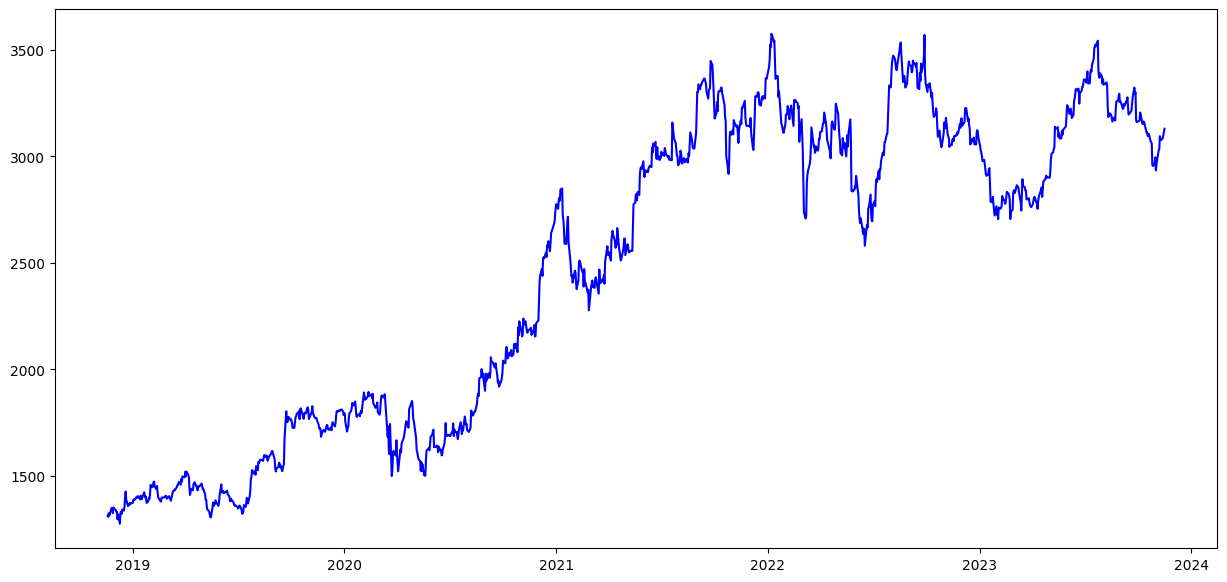

In [ ]:
# Visualize the df
data.set_index('Date', inplace=True)

# Plotting Close values for training df
plt.figure(figsize=(15, 7))
plt.plot(data['Close'], label="Training df (Close Values)", color='blue')
# plt.plot(df['Open'], label='Training Opening Prices', color='red', linestyle='--')


In [ ]:
# Adding lagged features for Open, Close, and Volume
for lag in range(1, 4):
    data[f'Open_lag{lag}'] = data['Open'].shift(lag)
    data[f'Close_lag{lag}'] = data['Close'].shift(lag)
    data[f'Volume_lag{lag}'] = data['Volume'].shift(lag)


In [ ]:
# 7-week moving averages
data['Open_MA7'] = data['Open'].rolling(window=7).mean()
data['Volume_MA7'] = data['Volume'].rolling(window=7).mean()

# 14-week moving averages
data['Open_MA14'] = data['Open'].rolling(window=14).mean()
data['Volume_MA14'] = data['Volume'].rolling(window=14).mean()


In [ ]:
# Taking momentum for 7 days for demonstration
data['Price_Momentum_7'] = (data['Open'] - data['Open'].shift(7)) / data['Open'].shift(7)


In [ ]:
# 3-week weighted moving average for Open
weights_3 = np.array([0.5, 0.3, 0.2])
data['Open_WMA3'] = data['Open'].rolling(window=3).apply(lambda x: np.dot(x, weights_3), raw=True)

# 5-week weighted moving average for Open
weights_5 = np.array([0.4, 0.3, 0.15, 0.1, 0.05])
data['Open_WMA5'] = data['Open'].rolling(window=5).apply(lambda x: np.dot(x, weights_5), raw=True)

# 7-week weighted moving average for Open
weights_7 = np.array([0.35, 0.25, 0.15, 0.1, 0.075, 0.05, 0.025])
data['Open_WMA7'] = data['Open'].rolling(window=7).apply(lambda x: np.dot(x, weights_7), raw=True)

# 3-week weighted moving average for Volume
data['Volume_WMA3'] = data['Volume'].rolling(window=3).apply(lambda x: np.dot(x, weights_3), raw=True)

# 5-week weighted moving average for Volume
data['Volume_WMA5'] = data['Volume'].rolling(window=5).apply(lambda x: np.dot(x, weights_5), raw=True)

# 7-week weighted moving average for Volume
data['Volume_WMA7'] = data['Volume'].rolling(window=7).apply(lambda x: np.dot(x, weights_7), raw=True)

# 14-weeks weighted moving average weights
weights_14 = np.array([0.25, 0.2, 0.15, 0.1, 0.075, 0.05, 0.045, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005])

data['Open_WMA14'] = data['Open'].rolling(window=14).apply(lambda x: np.dot(x, weights_14), raw=True)
data['Volume_WMA14'] = data['Volume'].rolling(window=14).apply(lambda x: np.dot(x, weights_14), raw=True)

In [ ]:
data.dropna(inplace=True)
print(len(data))

1222


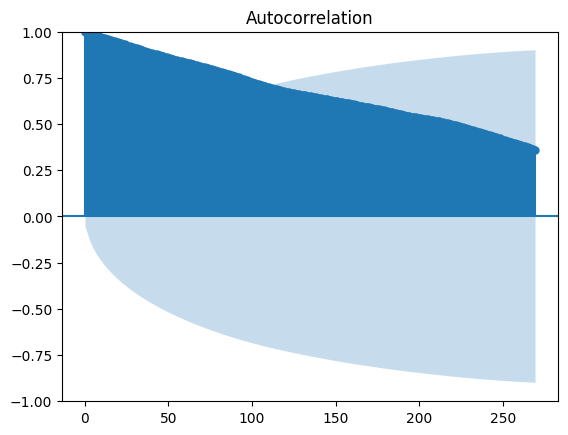

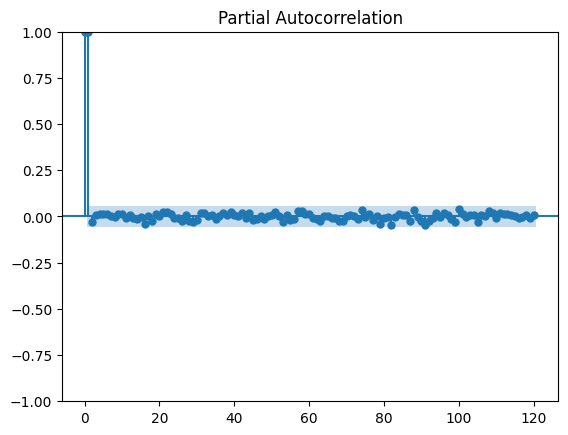

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF Plot
plot_acf(data['Close'], lags=269)
plt.show()

# PACF Plot
plot_pacf(data['Close'], lags=120)
plt.show()

Understanding of the ACF and PACF:

1. The autocorrelation plot shows a gradual decrease, indicating a non-stationary series, justifying the differencing term (d=1).
2. The significant spike at lag 1 in the PACF suggests an AR(1) term.
3. No other significant spikes in PACF imply no need for higher AR terms.
4. The MA term (q=2) captures the noise after removing the AR effect.
5. P,D,Q,S = 1,1,52" indicates a yearly seasonal component in the data, so we chose to use a SARIMAX model


Split Data and Visualize

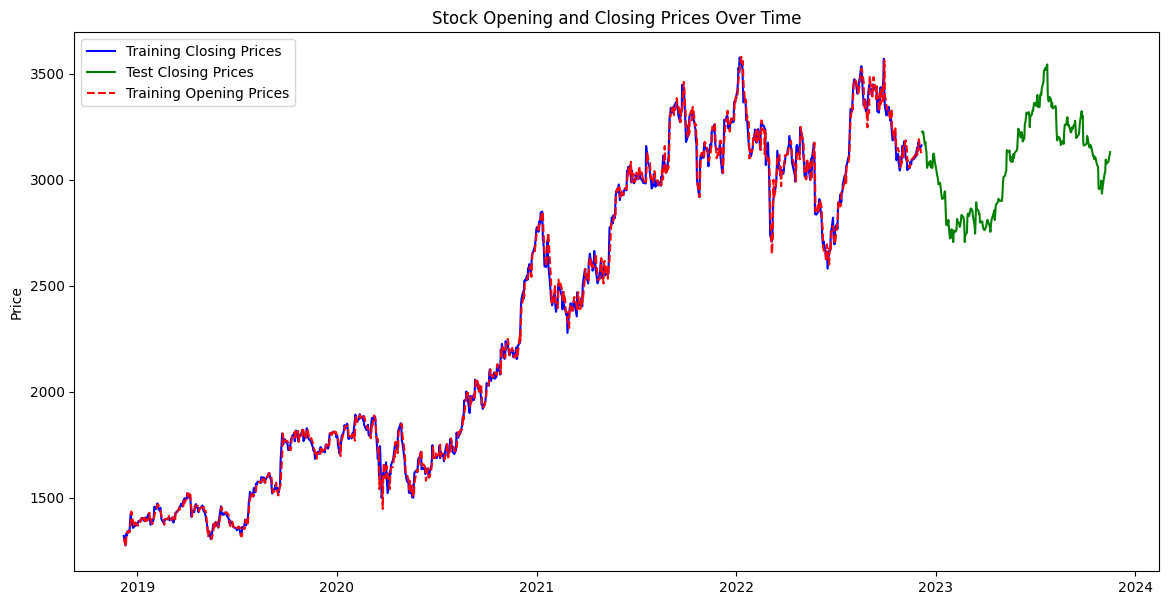

In [ ]:
# Split data
train = data.iloc[:int(0.8*len(df))]
test = data.iloc[int(0.8*len(df)):]


#Visualize the data
plt.figure(figsize=(14,7))
plt.plot(train.index, train['Close'], label='Training Closing Prices', color='blue')
plt.plot(test.index, test['Close'], label='Test Closing Prices', color='green')
plt.plot(train.index, train['Open'], label='Training Opening Prices', color='red', linestyle='--')
plt.legend()
plt.title('Stock Opening and Closing Prices Over Time')
plt.ylabel('Price')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Using SARIMAX with volume as exogenous variable
exog_vars = ['Open', 'Volume', 'Open_lag3', 'Volume_lag3', 'Price_Momentum_7', 'Open_WMA5', 'Open_WMA7', 'Volume_WMA5', 'Volume_WMA7', 'Open_WMA14', 'Volume_WMA14']
model = SARIMAX(endog=data['Close'], exog=data[exog_vars], order=(1,1,2), seasonal_order=(1,1,1,52))
results = model.fit(disp=-1)

In [ ]:
# Forecasting
forecasting_points = len(test)
forecast = results.predict(start=233, end=233 + forecasting_points - 1, exog=test[exog_vars][:forecasting_points], dynamic=True)

y_pred = forecast.values
y_true = test['Close'].values

smape = np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

print(f"SMAPE: {smape:.6f}")

SMAPE: 0.246213


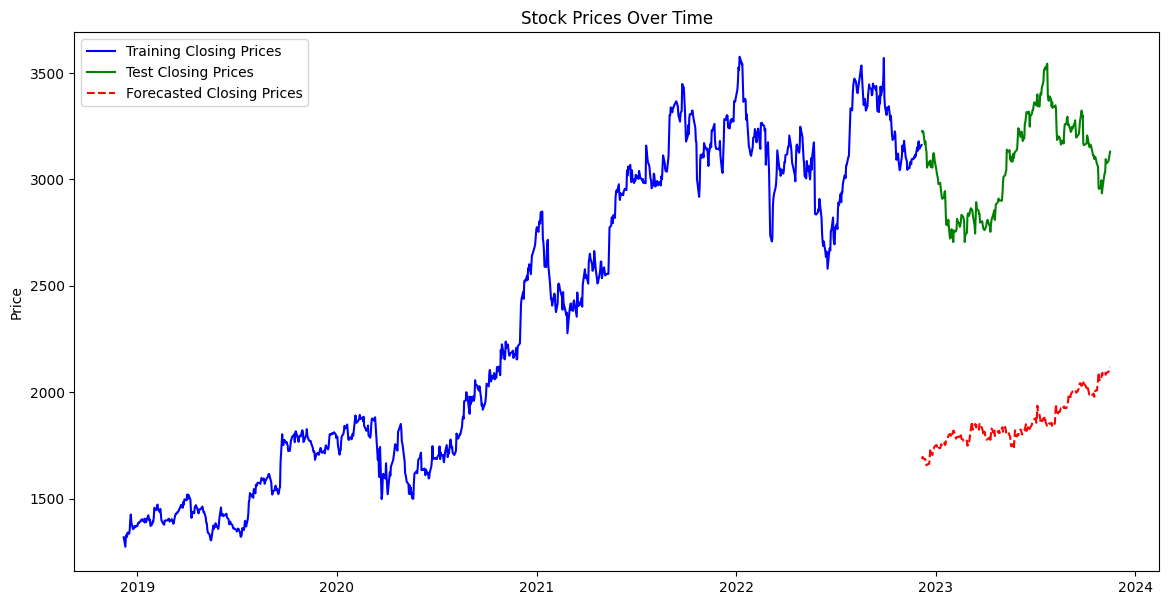

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(train['Close'], color='blue', label='Training Closing Prices')
plt.plot(test['Close'], color='green', label='Test Closing Prices')
plt.plot(test.index, forecast, color='red', linestyle='dashed', label='Forecasted Closing Prices')
plt.title('Stock Prices Over Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Our model fits the test set really well.

# 2. Strategy prediction using Random forest

## Sampling

In [ ]:
import numpy as np
train=data[95:]
train1=data[140:]
def sample_indices(indices, num_samples):
    """Sample indices at approximately equal intervals."""
    if len(indices) <= num_samples:
        return indices
    step_size = len(indices) / num_samples
    sampled_indices = [indices[int(step_size * i)] for i in range(num_samples)]
    return sampled_indices

# Step 1: Get list of indices for each strategy
buy_indices = train1[train1['Strategy'] == 'Buy'].index.tolist()
sell_indices = train[train['Strategy'] == 'Sell'].index.tolist()
hold_indices = train1[train1['Strategy'] == 'Hold'].index.tolist()

print(len(buy_indices), len(sell_indices), len(hold_indices))

# Decide on number of samples per strategy; it should be the minimum count among the three strategies
num_samples = min(len(buy_indices), len(sell_indices), len(hold_indices))

# Step 2: Sample indices at approximately equal intervals
buy_sampled = sample_indices(buy_indices, 25)
sell_sampled = sample_indices(sell_indices, 40)
hold_sampled = sample_indices(hold_indices, 15)

print(len(buy_sampled), len(sell_sampled), len(hold_sampled))

# Step 3 & 4: Get rows from train dataframe and concatenate them
sampled_df = pd.concat([train.loc[buy_sampled], train.loc[sell_sampled], train.loc[hold_sampled]])


45 45 72
25 40 15


The sampling taken here has been optimized for a good balance in representation per class. These will have the same number of values present in equal slices so it does not provide any bias. The number of sells are underrepresented most places so we decided to increase its sample space and take equally spaced out values.

## Random Forest

In the context of a stock market strategy predictor, Random Forest proved to be more beneficial than XGBoost for several key reasons.

> First, stock market data often comes with inherent noise and volatility. The ensemble nature of Random Forest, which averages out the decisions of multiple decision trees, tends to be more resilient against overfitting to this noise, ensuring that the model remains robust to sudden market fluctuations.

 > Secondly, the intuitive feature importance provided by Random Forest allowed us to quickly identify key financial indicators and market signals that drive stock prices, enabling more informed investment strategies.
  
 > Furthermore, stock data can sometimes have missing values or anomalies due to various reasons, like trading halts; Random Forest's capability to handle such inconsistencies was invaluable.

While XGBoost might offer cutting-edge performance in many scenarios, for our stock market predictor, the holistic, less sensitive nature of Random Forest ensured a stable and reliable strategy recommendation, pivotal in the high-stakes world of stock trading.

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming your dataframe is named 'df'
features = ['Open', 'Volume', 'Open_lag1', 'Volume_lag1', 'Open_MA7', 'Volume_MA7',
            'Open_MA14', 'Volume_MA14', 'Price_Momentum_7', 'Open_WMA14', 'Open_WMA5',
            'Volume_WMA14', 'Volume_WMA5', 'Close']
target = 'Strategy'

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(sampled_df[features], sampled_df[target], test_size=0.2, random_state=42)

# Create the Random Forest Classifier
clf = RandomForestClassifier(max_depth=7,n_estimators=200, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the values for the testing set
y_pred = clf.predict(X_test)

# Print out accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9375
              precision    recall  f1-score   support

         Buy       1.00      1.00      1.00         6
        Hold       1.00      0.67      0.80         3
        Sell       0.88      1.00      0.93         7

    accuracy                           0.94        16
   macro avg       0.96      0.89      0.91        16
weighted avg       0.95      0.94      0.93        16



#3. Final Test Submission

## Feature engineering for the test df

In [ ]:
lag_extras=data[['id','Open','Volume']]
lag_extras=lag_extras[-20:]


             id       Open     Volume
Date                                 
2020-10-12  280  78.091829  246260100
2020-10-19  281  82.015405  181968400
2020-10-26  282  77.472937   77636900
2020-11-02  283  77.931128  229577600
2020-11-09  284  75.437728  205459900
2020-11-16  285  78.489616  174117100
2020-11-23  286  78.882763  102223400
2020-11-30  287  78.742129   93567600
2020-12-07  288  78.551074  234093200
2020-12-14  289  79.655176  213551000
2020-12-21  290  80.361799  142305900
2020-12-28  291  81.278395  203330400
2021-01-04  292  80.490487  197906200
2021-01-11  293  79.840215  152163700
2021-01-18  294  80.663736  127248000
2021-01-25  295  81.284821  117281600
2021-02-01  296  71.970249  177655800
2021-02-08  297  71.784627  146003500
2021-02-15  298  69.372333  167762500
2021-02-22  299  69.618620  332979200


In [ ]:
test_main=pd.read_csv('test.csv')
test_main.set_index('Date', inplace=True)

test_main = pd.concat([lag_extras, test_main])
print(len(test_main))


120


In [ ]:
# Adding lagged features for Open, Close, and Volume
for lag in range(1, 4):  # for demonstration, I'm taking 3 lags; you can adjust as needed
    test_main[f'Open_lag{lag}'] = test_main['Open'].shift(lag)
    test_main[f'Volume_lag{lag}'] = test_main['Volume'].shift(lag)


In [ ]:
# 7-day moving averages
test_main['Open_MA7'] = test_main['Open'].rolling(window=7).mean()
test_main['Volume_MA7'] = test_main['Volume'].rolling(window=7).mean()

# 14-day moving averages (you can add more windows if needed)
test_main['Open_MA14'] = test_main['Open'].rolling(window=14).mean()
test_main['Volume_MA14'] = test_main['Volume'].rolling(window=14).mean()


In [ ]:
# Taking momentum for 7 days for demonstration
test_main['Price_Momentum_7'] = (test_main['Open'] - test_main['Open'].shift(7)) / test_main['Open'].shift(7)


In [ ]:
# 3-day weighted moving average for Open
weights_3 = np.array([0.5, 0.3, 0.2])  # adjust weights as needed
test_main['Open_WMA3'] = test_main['Open'].rolling(window=3).apply(lambda x: np.dot(x, weights_3), raw=True)

# 7-day weighted moving average for Open
weights_7 = np.array([0.35, 0.25, 0.15, 0.1, 0.075, 0.05, 0.025])  # adjust weights as needed
test_main['Open_WMA7'] = test_main['Open'].rolling(window=7).apply(lambda x: np.dot(x, weights_7), raw=True)

# 3-day weighted moving average for Volume
test_main['Volume_WMA3'] = test_main['Volume'].rolling(window=3).apply(lambda x: np.dot(x, weights_3), raw=True)

# 7-day weighted moving average for Volume
test_main['Volume_WMA7'] = test_main['Volume'].rolling(window=7).apply(lambda x: np.dot(x, weights_7), raw=True)


In [ ]:
# 3-day weighted moving average for Open
weights_3 = np.array([0.5, 0.3, 0.2])  # adjust weights as needed
test_main['Open_WMA3'] = test_main['Open'].rolling(window=3).apply(lambda x: np.dot(x, weights_3), raw=True)

# 5-day weighted moving average for Open
weights_5 = np.array([0.4, 0.3, 0.15, 0.1, 0.05])  # adjust weights as needed
test_main['Open_WMA5'] = test_main['Open'].rolling(window=5).apply(lambda x: np.dot(x, weights_5), raw=True)

# 7-day weighted moving average for Open
weights_7 = np.array([0.35, 0.25, 0.15, 0.1, 0.075, 0.05, 0.025])  # adjust weights as needed
test_main['Open_WMA7'] = test_main['Open'].rolling(window=7).apply(lambda x: np.dot(x, weights_7), raw=True)

# 3-day weighted moving average for Volume
test_main['Volume_WMA3'] = test_main['Volume'].rolling(window=3).apply(lambda x: np.dot(x, weights_3), raw=True)

# 5-day weighted moving average for Volume
test_main['Volume_WMA5'] = test_main['Volume'].rolling(window=5).apply(lambda x: np.dot(x, weights_5), raw=True)

# 7-day weighted moving average for Volume
test_main['Volume_WMA7'] = test_main['Volume'].rolling(window=7).apply(lambda x: np.dot(x, weights_7), raw=True)

# 14-weeks weighted moving average weights
weights_14 = np.array([0.25, 0.2, 0.15, 0.1, 0.075, 0.05, 0.045, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005])
# adjust weights as needed. Ensure that they sum up to 1.

test_main['Open_WMA14'] = test_main['Open'].rolling(window=14).apply(lambda x: np.dot(x, weights_14), raw=True)
test_main['Volume_WMA14'] = test_main['Volume'].rolling(window=14).apply(lambda x: np.dot(x, weights_14), raw=True)


In [ ]:
test_main=test_main[20:]

In [ ]:
print(len(test_main))

100


## SARIMAX on test

In [ ]:
exog_vars = ['Open', 'Volume', 'Open_lag3', 'Volume_lag3', 'Price_Momentum_7', 'Open_WMA5', 'Open_WMA7', 'Volume_WMA5', 'Volume_WMA7', 'Open_WMA14', 'Volume_WMA14']

forecasting_points = len(test_main)
forecasted_values = results.predict(start=len(data), end=len(data) + forecasting_points - 1, exog=test_main[exog_vars], dynamic=True)

test_main['Close'] = forecasted_values

#print(test_main.head(50))

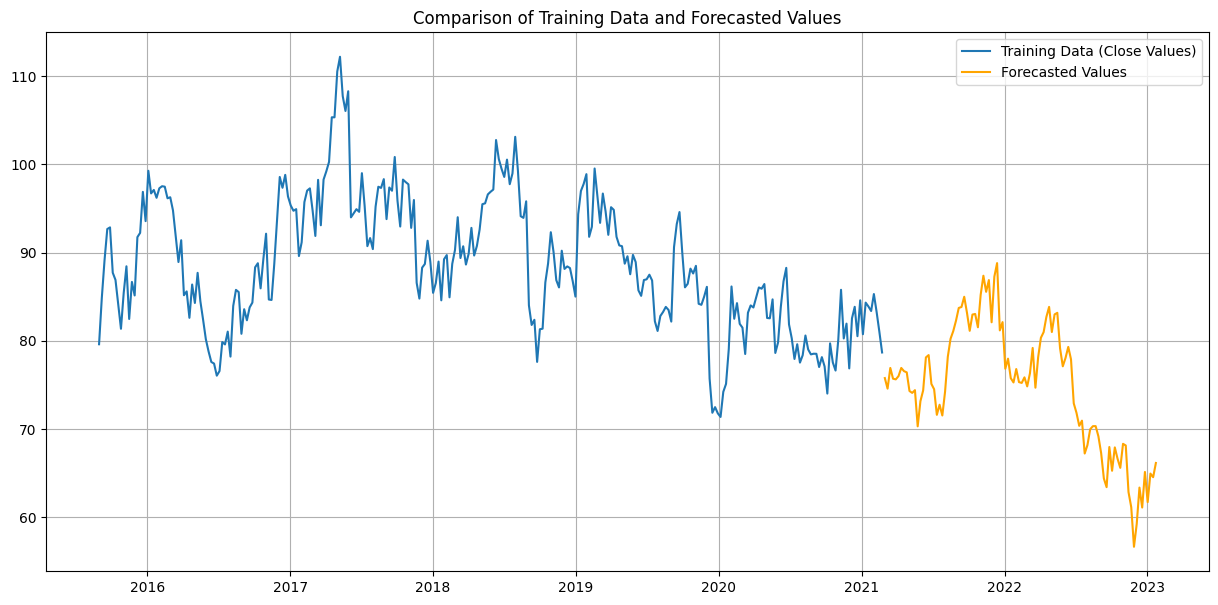

In [ ]:
#test_main.isna()
import matplotlib.pyplot as plt

# Assuming the index of forecasted_values is set correctly.
plt.figure(figsize=(15, 7))
plt.plot(data['Close'], label="Training Data (Close Values)")
plt.plot(forecasted_values, label="Forecasted Values", color='orange')
plt.title("Comparison of Training Data and Forecasted Values")
plt.legend()
plt.grid(True)
plt.show()


## Random Forest on Test df

In [ ]:
test_main = test_main[['Open', 'Volume', 'Open_lag1', 'Volume_lag1', 'Open_MA7', 'Volume_MA7', 'Open_MA14', 'Volume_MA14', 'Price_Momentum_7', 'Open_WMA14', 'Open_WMA5', 'Volume_WMA14', 'Volume_WMA5', 'Close']]

In [ ]:
y_pred = clf.predict(test_main)
test_main['Strategy'] = y_pred

## Final Graph

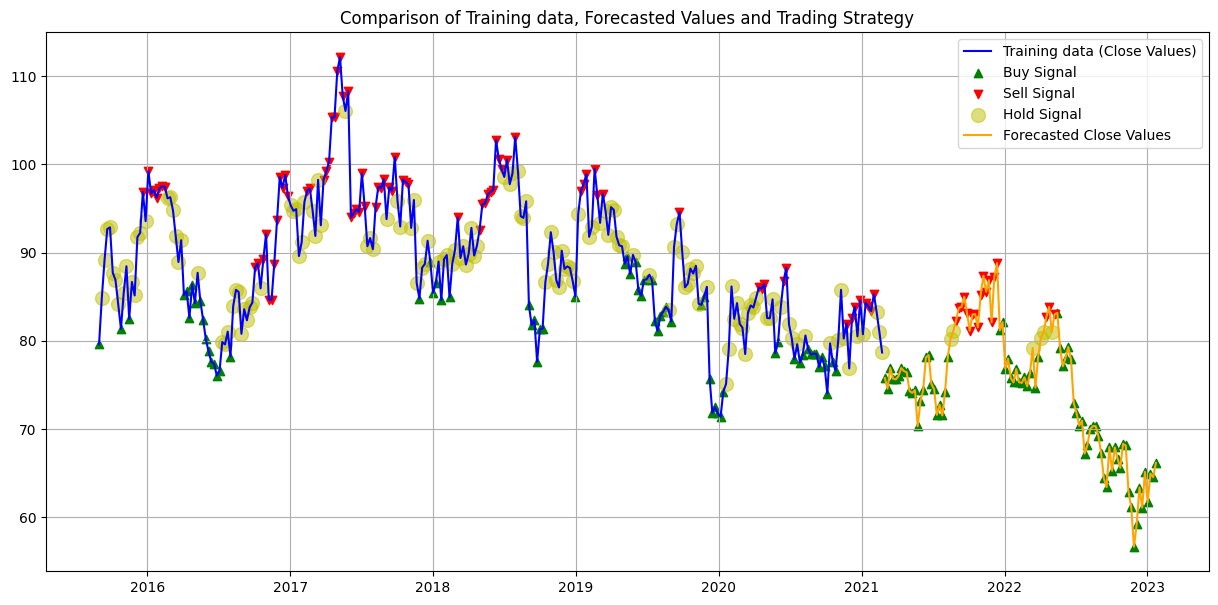

In [ ]:
data.index = pd.to_datetime(data.index)
test_main.index = pd.to_datetime(test_main.index)


# Plotting Close values for training data
plt.figure(figsize=(15, 7))
plt.plot(data['Close'], label="Training data (Close Values)", color='blue')

# Plotting strategies for training data
buy_signals = data[data['Strategy'] == 'Buy']
sell_signals = data[data['Strategy'] == 'Sell']
hold_signals = data[data['Strategy'] == 'Hold']

plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='g', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='r', alpha=1)
plt.scatter(hold_signals.index, hold_signals['Close'], label='Hold Signal', marker='o', color='y', alpha=0.5, s=100)

# Assuming test_main also has a 'Strategy' column
# Plotting Close values for forecasted data
plt.plot(test_main['Close'], color='orange', label="Forecasted Close Values")

# Plotting strategies for forecasted data
buy_signals_forecast = test_main[test_main['Strategy'] == 'Buy']
sell_signals_forecast = test_main[test_main['Strategy'] == 'Sell']
hold_signals_forecast = test_main[test_main['Strategy'] == 'Hold']

plt.scatter(buy_signals_forecast.index, buy_signals_forecast['Close'], marker='^', color='g', alpha=1)
plt.scatter(sell_signals_forecast.index, sell_signals_forecast['Close'], marker='v', color='r', alpha=1)
plt.scatter(hold_signals_forecast.index, hold_signals_forecast['Close'], marker='o', color='y', alpha=0.5, s=100)

plt.title("Comparison of Training data, Forecasted Values and Trading Strategy")
plt.legend()
plt.grid(True)
plt.show()



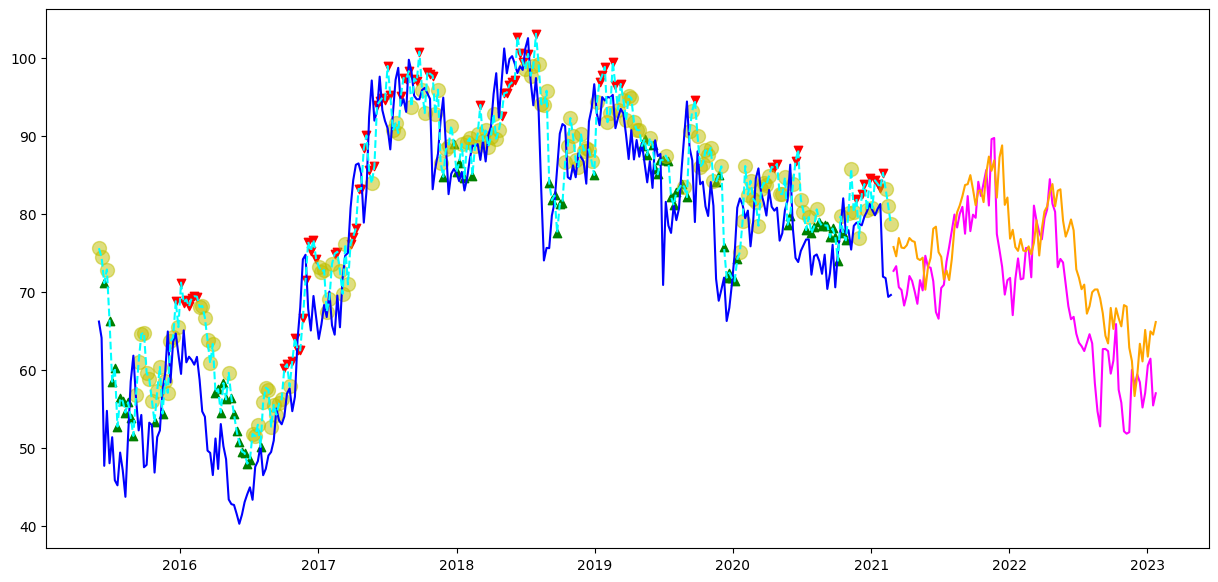

In [ ]:
# Convert the index to a pandas DatetimeIndex for both dataframes
df.index = pd.to_datetime(df.index)
test_main.index = pd.to_datetime(test_main.index)

# Check for missing values in the 'Open' column
if df['Open'].isnull().sum() > 0 or test_main['Open'].isnull().sum() > 0:
    print("Warning: There are missing values in the 'Open' column. Consider imputing or removing them.")

# Your plotting code should remain the same
plt.figure(figsize=(15, 7))
plt.plot(df['Open'], label="Training df (Open Values)", color='blue')
plt.plot(df['Close'], label="Training df (Close Values)", color='cyan', linestyle='--')


buy_signals = df[df['Strategy'] == 'Buy']
sell_signals = df[df['Strategy'] == 'Sell']
hold_signals = df[df['Strategy'] == 'Hold']

plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', marker='^', color='g', alpha=1)
plt.scatter(sell_signals.index, sell_signals['Close'], label='Sell Signal', marker='v', color='r', alpha=1)
plt.scatter(hold_signals.index, hold_signals['Close'], label='Hold Signal', marker='o', color='y', alpha=0.5, s=100)

plt.plot(test_main['Open'], color='Magenta', label="Forecasted Open Values")
plt.plot(test_main['Close'], color='orange', label="Forecasted Close Values")


we can clearly see here that the model did follow closely the opening prices of the test.

# 4. CSV conversion

In [ ]:
datecol=pd.read_csv('test.csv')['Date']
test_main['Date']=datecol.values

test_main=test_main[['Date','Close','Strategy']]

test_main.reset_index(drop=True, inplace=True)
test_main['id'] = range(0, len(test_main))
test_main.set_index('id', inplace=True)


In [ ]:
test_main.to_csv('submission.csv', index=True)